# Document Classification with Word Embeddings

In this previous activity, we have enough fun playinng around the word embeddings. 
Now, we get to the stage that we will make real use of them, i.e., we are going to build on these embeddings machine learing models for document classification. 😊


## The Dataset
Same as in the previous activity, the document collection that we are going to use is the BBC News Dataset. For the origin of the dataset, please refer to [here](http://mlg.ucd.ie/datasets/bbc.html)
To be brief, the dataset consists of 2225 documents from the BBC news website corresponding to stories in five topical areas, i.e., class Labels (business, entertainment, politics, sport, tech).

In this activity, instead of using the raw dataset, we will utilised the pre-processed clean dataset we saved in our previous Activity 3 Generating Feature Vectors.
Recall that at the end of Activity 3, we saved the pre-processed articles in a txt file named `bbcNews.txt`, where, each row is a document, with tokens seperated by whitespace.

Before continue, please make sure you have the following files in the same folder as this jupyter notebook:
* `bbcNews.txt`: contains the pre-process BBC news articles
* `labels.csv`: contains the label/class of each article.

In [1]:
# logging for event tracking
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Let's read in the labels and article data, and construct a single dataframe to store them correspondingly. 
Note that the order of the articles are the same as the labels data, as they are all in sorted order of document names. 

In [2]:
# reading the labels file
import pandas as pd
df = pd.read_csv('job_ad.csv')

# print out 5 samples
df.sample(5)

,Title,Webindex,Company,Description,Tokenized Description,Category
642,Recruitment Branch Manager Birmingham,67332022,Ruth Moran,Recruitment Branch Manager Birmingham Basic sa...,recruitment branch manager birmingham basic sa...,Sales
643,Homecare Nurse HPN Therapies Manchester Salford,70264328,BUPA Home Healthcare,"Passionate about making lives better, Bupa is ...",passionate making lives bupa dedicated clinica...,Healthcare_Nursing
735,Senior Staff Nurse,69587191,Oxford University Hospitals NHS Trust,THE CHURCHILL HOSPITAL Senior Staff Nurse Job ...,hospital senior staff nurse job ref ng salary ...,Healthcare_Nursing
225,Digital Test Engineer,72453749,Enterprise Recruitment,Digital Test Engineer Are you an Digital Test ...,digital test engineer digital test engineer in...,Engineering
688,Finance Analyst,68711980,Exibio Financial Recruitment,An experienced Finance Analyst is required by ...,experienced finance analyst required large ret...,Accounting_Finance


Read in the article text, and creates another list to store the tokenized version of the article text accordingly.

Pre-trained embeddigns:
- `preTW2v_wv`: Word2Vec embeddings pre-trained from Google news 300 dataset
- `preTGloVe_wv`: pre-trained GloVe embeddings 

Embeddings trained on the BBC News data:
- `bbcW2v_wv`
- `bbcFT_wv`

we are going to use them for document classification. 
Before we use, we will need to load them in this activity notebook one by one, and for each, we will need to construct the document representation, i.e., document embeddings based on the word embeddings.


## 1. Pre-trained word2vec model based on google news

The pre-trained embeddings we can download from the web. Here, we first download the pre-trained word2vec model based on google news.

In [3]:
# loading the pre-trained word2vec model based on google news
import gensim.downloader as api
preTW2v_wv = api.load('word2vec-google-news-300')

[--------------------------------------------------] 1.5% 24.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=-------------------------------------------------] 3.1% 51.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 5.3% 88.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 11.1% 184.0/1662.8MB downloaded

KeyboardInterrupt: 

Easy 😎well, but we then need to generate the document embeddings based on that.....

You should still remember how to play with these pre-trained embeddings, let's remind ourselves a little bit:

In [ ]:
preTW2v_wv['king'] # retrieve the embedding of a word 'king'

Ok, now we do something more seriously. 
Since we are going to explore the use of different language model for document classification in this activity, we will need to generate docment embeddings based on word embeddings a couple of times. 
Let's construct a function for this so that we can resue it later.

The following function takes:
* wv, an word:embedding dictionary or KeyedVectors; and 
* tk_txts, a list of tokenized texts, each of an article

as argument, it then does the following to generate the list of embedding vector representations, each for an article:
1. creates an empty dataframe `docs_vectors` to store the document embeddings of articles
2. it loop through every tokenized text:
    - creates an empty dataframe `temp` to store all the word embeddings of the article
    - for each word that exists in the word embeddings dictionary/keyedvectors, row bind the word embedding to `temp`
    - take the sum of each column to create the document vector, i.e., the embedding of an article
    - append the created document vector to the list of document vectors

In [9]:
def gen_docVecs(wv,tk_txts): # generate vector representation for documents
    docs_vectors = pd.DataFrame() # creating empty final dataframe
    #stopwords = nltk.corpus.stopwords.words('english') # if we haven't pre-processed the articles, it's a good idea to remove stop words

    for i in range(0,len(tk_txts)):
        tokens = tk_txts[i]
        temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
        doc_vector = temp.sum() # take the sum of each column
        docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
    return docs_vectors

In [10]:
# NOTE this can take some time to finish running
preTW2v_dvs = gen_docVecs(preTW2v_wv,df['tk_text'])
preTW2v_dvs.isna().any().sum() # check whether there is any null values in the document vectors dataframe.

0

0 null record  😊

### 1.1 Understand your task by tSNE

Alright! so we have the document embedding vector representation for each article now, we can proceed to the task of document classification. 
Before, we move on, a good habbit is to explore and understand how difficult the task is, whether there are too much noise in the data, making it impossible to clearly separate each category. 

One way to confirm that the feature space we are using is representative enough for our task (classifying articles into separate labels) to be solvable is to use dimensionality-reduction techniques: These methods project a high-dimensional vector into a lower number of dimensions, with different guarantees on this projection according to the method used. 
In this activity, we will use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), a popular dimensionality reduction technique used in many fields, including NLP.

Since we will do the same thing again and again when we try other embeddings, we will construct a function to do this again.
The following function `plotTSNE` takes the following arugments:
* labels, the lable/category of each article
* features, a numpy array of document embeddings, each for an article.

and projects the feature/document embedding vectors in a 2 dimension space and plot them out. 
It does the following:
1. get the set of classes, called `categories` (5 categories)
2. sample 30% of the data/document embeddings randomly, and record the indices selected
3. project the selected document embeddings in 2 dimensional space using tSNE, each document embedding now corresponds to a 2 dimensional vector in `projected_features`
4. plot them out as scatter plot and highlight different categories in different color

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
def plotTSNE(labels,features): # features as a numpy array, each element of the array is the document embedding of an article
    categories = sorted(labels.unique())
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(0)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each article, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

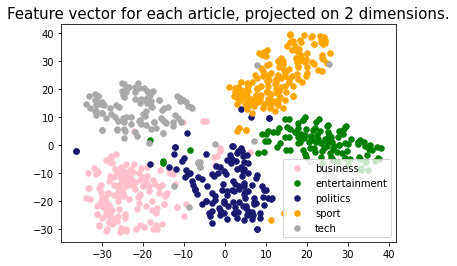

In [12]:
features = preTW2v_dvs.to_numpy() # convert the document vector dataframe to a numpy array
plotTSNE(df['Category'],features) # plot the tSNE to have a look

Oh! Not bad, there are a bit of noises, but overall, seems an easy one, the different categories are quite nicely seperated! Well~ if you remember this dataset prevoiusly, you would have a rough idea anyway, with the binary/count/tfidf vector representation, we have accuracy above 95% 😊
Ok, now, let's move on to the serious task: Document Classfication

### 1.2 Document classification using pre-trained Word2Vec from GoogleNews 300

In [13]:
seed = 0 # set a seed to make sure the experiment is reproducible

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(preTW2v_dvs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed) # increase the max_iter to 2000 for convergence
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9741496598639455

Ah ha, very similar to what we've seen before with the traditional bag-of-word models 🙄haha, not much advantage demonstrated......

>**Exercise**    
Here we will leave you a task to examin the cases of mis-classification, and perhaps compare it with the one we experience before with the binary/count/tf-idf vectors.


## 2. Our in-house trained Word2vec model on bbc News data

Ok, now let's see our own word2vec model trained on the BBC News data. 
Remember what I said before, we demonstrate how to save a model in the previous activity, and now we will show you how to load the saved model. 
Indeed, it's very simple, one line of code 😄, well, with Word2Vec library from Gensim. 

In [15]:
# loading the trained model based on bbc News data
from gensim.models import Word2Vec
bbc_w2v = Word2Vec.load("bbc_w2v.model") # load our saved model
print(bbc_w2v)
bbcW2v_wv = bbc_w2v.wv # extract the keyedvetors from the model

2021-09-15 03:22:14,290 : INFO : loading Word2Vec object from bbc_w2v.model
2021-09-15 03:22:14,326 : INFO : loading wv recursively from bbc_w2v.model.wv.* with mmap=None
2021-09-15 03:22:14,327 : INFO : setting ignored attribute cum_table to None
2021-09-15 03:22:14,428 : INFO : Word2Vec lifecycle event {'fname': 'bbc_w2v.model', 'datetime': '2021-09-15T03:22:14.428809', 'gensim': '4.1.1', 'python': '3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'loaded'}


Word2Vec(vocab=9994, vector_size=100, alpha=0.025)


Once loaded, we can then generate the document embeddings by calling our `gen_docVecs` function, it does all the jobs for us. hmm~ just love it 😀 

In [16]:
# NOTE this can take some time to finish running
bbcW2v_dvs = gen_docVecs(bbcW2v_wv,df['tk_text']) # generate document embeddings
pd.isnull(bbcW2v_dvs).isna().any().sum() # check whether there is any null values in the document vectors dataframe.

0

haha, ok, and as usualy, have a look at how representative our features are:

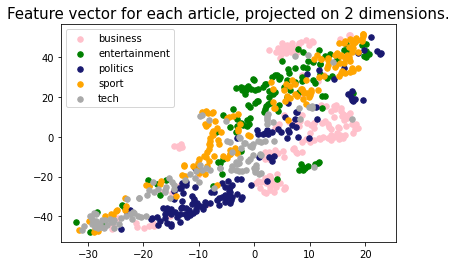

In [17]:
features = bbcW2v_dvs.to_numpy() # convert the document vector dataframe to a numpy array
plotTSNE(df['Category'],features)

oo~ oops~~ seems a bit messier than what we've seen before with the pre-trained Word2Vec. 
Try the actually classfication task and see whether that confirms our observation through tSNE.

In [18]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(bbcW2v_dvs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 2000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Users\E104857\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9496598639455782

Oh, so the performance is a bit lower than the pre-trained model. 
There could be many different reasons for this, also remember the dimensions of the word embeddings (and thus, the document embeddings) are different. 
The pre-trained Word2Vec we tried before is 300 dimension, and our in-house trained model is 100 dimension only. 
Although, it is not guarantee that larger dimension will give a better results.
So, we leave another task for you:
> **Exercise**  
Trained Word2Vec model on the BBC News dataset using other dimensions, e.g., 50, 200, 300, and use them to do document classifcation here. Compare the performance. 

## 3. Pre-trained GloVe word embeddings

In this section, we move on to try the pre-trained GloVe word embeddings. 
Again, the pre-trained GloVe embeddings are available [here](https://nlp.stanford.edu/projects/glove/), and we will use the 6B vesion here. 
Remember, if you don't have them yet, you have to download them (can do this by putting the following code):

```
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip -d glove
```

Hmm~ we really don't want to do the same thing again and again, or copy paste the code from the previous activity to construct the GloVe vectors from the downloaded files. 
Therefore, we move this block of code as a function `loadGloVe` and move it to external modules `utils`, and we just need to do an import. 
You feel free to explore the external file `utils.py`.

In [25]:
from utils import loadGloVe

fPath = "glove/glove.6B.100d.txt"
preTGloVe_wv = loadGloVe(fPath) # load the GloVe embeddings

Found 400000 word vectors.


In [26]:
# NOTE this can take some time to finish running
preTGloVe_dvs = gen_docVecs(preTGloVe_wv,df['tk_text']) # generate document embeddings
preTGloVe_dvs.isna().any().sum() # check whether there is any null values in the document vectors dataframe.

0

See how the classes are seperated in feature space:

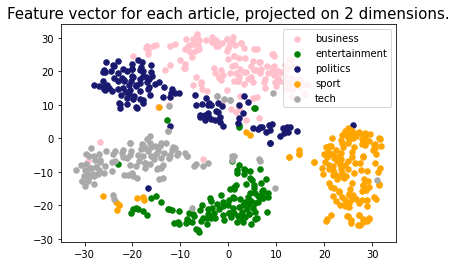

In [27]:
features = preTGloVe_dvs.to_numpy()
plotTSNE(df['Category'],features)

Seem all fine, we then build a logistic classification model based on the document embeddings:

In [28]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(preTGloVe_dvs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Users\E104857\Anaconda3\envs\Python36\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9714285714285714

## 3. FastText model trained on BBC News data

Finally, we experiment the FastText embeddings. 
Similar, we:
* load the FastText model saved in our prevoius activity;
* generate document embeddings based on the load FastText word embeddings;
* explore the reprensentiveness of the features through tSNE;
* bulid the logistic regression model based on the generated document embeddings for news classfication.

In [29]:
# loading the trained Fasttext model based on bbc News data
from gensim.models.fasttext import FastText
bbcFT = FastText.load("bbcFT.model")
print(bbcFT)
bbcFT_wv= bbcFT.wv

2021-09-15 03:53:48,861 : INFO : loading FastText object from bbcFT.model
2021-09-15 03:53:48,910 : INFO : loading wv recursively from bbcFT.model.wv.* with mmap=None
2021-09-15 03:53:48,912 : INFO : loading vectors_ngrams from bbcFT.model.wv.vectors_ngrams.npy with mmap=None
2021-09-15 03:53:52,142 : INFO : setting ignored attribute vectors to None
2021-09-15 03:53:52,142 : INFO : setting ignored attribute buckets_word to None
2021-09-15 03:53:52,752 : INFO : setting ignored attribute cum_table to None
2021-09-15 03:53:52,864 : INFO : FastText lifecycle event {'fname': 'bbcFT.model', 'datetime': '2021-09-15T03:53:52.861845', 'gensim': '4.1.1', 'python': '3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.18362-SP0', 'event': 'loaded'}


FastText(vocab=10485, vector_size=100, alpha=0.025)


In [ ]:
# NOTE this can take some time to finish running
# generate document embeddings
bbcFT_dvs = gen_docVecs(bbcFT_wv,df['tk_text'])
bbcFT_dvs.isna().any().sum()

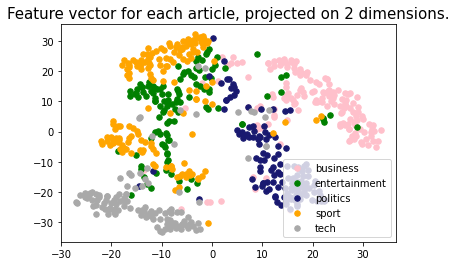

In [25]:
# explore feature space
features = bbcFT_dvs.to_numpy()
plotTSNE(df['Category'],features)

er~~~ for some categories seems a bit messy also.....

In [26]:
# build the classfication model and report results
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(bbcFT_dvs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

/Users/gregp/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9414965986394558

## 4. Generating TF-IDF weighted document vectors

Ok, I hope you have lots of fun building document embeddings based on varoius word embedding models. 
Previously, when we generate the document embeddings, we just sum up the embeddings vector of each tokenized word in the article, a bit simplicity 🤔

In this section, let's make it a bit more challenging, we are going to build the tf-idf document embeddings. 
What does that mean? 🤨
Hmm~~ it's not magic, we just do a weigthed sum of the word embedding vectors, however, the weight here, refers to the tf-idf weight of the word. 

If you already forgot about what is `tf-idf`, please refer to Activity 3 Pre-processing Text and Generating Features. 
Otherwise, move on!
So we've generated the tf-idf vector representation of documents in Activity 3 and saved in a txt file called `bbcNews_tVector.txt`. The format of this file is:
- each line represents an article;
- each line is of the format 'w_index:weight w_index:weight ......' 

Oh, but we don't have that word index `w_index` here in this activity, what should we do? 🤔
ah ha, we also saved the vocabulary in a file `bbcNews_voc`, in which each line is a word, and of the format `index,word`. 
Theresore, based on these two files, we can create a word:weight mapping for each tokenized word in a document!

Ok, in the following couple block of codes, this is exactly what we are trying to do, step by step. 
- the `gen_vocIndex` function reads the the vocabulary file, and create an w_index:word dictionary

In [27]:
def gen_vocIndex(voc_fname):
    with open(voc_fname) as vocf: 
        voc_Ind = [l.split(',') for l in vocf.read().splitlines()] # each line is 'index,word'
    return {int(vi[0]):vi[1] for vi in voc_Ind}


# Generates the w_index:word dictionary
voc_fname = './bbcNews_voc.txt' # path for the vocabulary
voc_dict = gen_vocIndex(voc_fname)
voc_dict

{0: "a'",
 1: 'a-half',
 2: 'a-level',
 3: 'a-levels',
 4: 'a-list',
 5: 'a.d.',
 6: 'aaa',
 7: "aaa's",
 8: 'aaas',
 9: 'aac',
 10: 'aaron',
 11: 'abacus',
 12: 'abandon',
 13: 'abandoned',
 14: 'abandoning',
 15: 'abandonment',
 16: 'abating',
 17: 'abba',
 18: "abba's",
 19: 'abbas',
 20: 'abbasi',
 21: 'abbey',
 22: 'abbott',
 23: 'abc',
 24: 'abdellatif',
 25: 'abdication',
 26: 'abdominal',
 27: 'abdullah',
 28: 'aberdeen',
 29: 'abeyie',
 30: 'abhorrent',
 31: 'abide',
 32: 'abided',
 33: 'abiding',
 34: 'abilities',
 35: 'ability',
 36: 'able',
 37: 'able-bodied',
 38: 'abn',
 39: 'abolish',
 40: 'abolished',
 41: 'abolishing',
 42: 'abortion',
 43: 'abortionist',
 44: 'abraham',
 45: 'abramovich',
 46: "abramovich's",
 47: 'abroad',
 48: 'absa',
 49: 'absence',
 50: 'absent',
 51: 'absentee',
 52: 'absolute',
 53: 'absolutely',
 54: 'absorb',
 55: 'absorbed',
 56: 'absorbing',
 57: 'absorbs',
 58: 'absurd',
 59: 'abundance',
 60: 'aburizal',
 61: 'abuse',
 62: 'abused',
 63: '

- the `doc_wordweights` function takes the tfidf document vector file, as well as the w_index:word dictionary, creates the mapping between w_index and the actual word, and creates a dictionary of word:weight or each unique word appear in the document.

In [28]:
def doc_wordweights(fName_tVectors, voc_dict):
    tfidf_weights = [] # a list to store the  word:weight dictionaries of documents
    
    with open(fName_tVectors) as tVecf: 
        tVectors = tVecf.read().splitlines() # each line is a tfidf vector representation of a document in string format 'word_index:weight word_index:weight .......'
    for tv in tVectors: # for each tfidf document vector
        tv = tv.strip()
        weights = tv.split(' ') # list of 'word_index:weight' entries
        weights = [w.split(':') for w in weights] # change the format of weight to a list of '[word_index,weight]' entries
        wordweight_dict = {voc_dict[int(w[0])]:w[1] for w in weights} # construct the weight dictionary, where each entry is 'word:weight'
        tfidf_weights.append(wordweight_dict) 
    return tfidf_weights

fName_tVectors = 'bbcNews_tVector.txt'
tfidf_weights = doc_wordweights(fName_tVectors, voc_dict)

In [29]:
# take a look at the tfidf word weights dictionary of the first document
tfidf_weights[0]

{'year': '0.02172550050662404',
 'world': '0.029389015433271874',
 'working': '0.044292026808015',
 'visiting': '0.07222715579212276',
 'visas': '0.3046502180924083',
 'visa': '0.22674316817874562',
 'uphill': '0.09024251451225522',
 'union': '0.15136556796475625',
 'uk': '0.03237195111969164',
 'travel': '0.06297680542357942',
 'tougher': '0.0762321820047836',
 'tough': '0.05312248617163384',
 'thanks': '0.06540996583652363',
 'tape': '0.07763826387625275',
 'tackle': '0.12019616154314977',
 'success': '0.04807046974078493',
 'succeeding': '0.09229972232892607',
 'succeed': '0.06876386610398275',
 'struggle': '0.07127350486148784',
 'stance': '0.07558105605958187',
 'sport': '0.05243205111228791',
 'sponsor': '0.09229972232892607',
 'spokeswoman': '0.06091959760690855',
 'spokesman': '0.041399666276002056',
 'situation': '0.053850599527964095',
 'singer': '0.0552983208547527',
 'simply': '0.05166924723836521',
 'seller': '0.16842115320346146',
 'seen': '0.08221696321178629',
 'secreta

Ok, once we have the word:weight dictionary of each document, now we can construct the tf-idf weighted document embeddings. 
* the following `gen_docVecs` function is an revision/extension of the previous written function, that takes the word embeddings dictionary, the tokenized text of articles, and the tfidf weights (list of word:weight dictionaries, one for each article) as arguments, and generates the document embeddings:
 1. creates an empty dataframe `docs_vectors` to store the document embeddings of articles
  2. it loop through every tokenized text:
    - creates an empty dataframe `temp` to store all the word embeddings of the article
    - for each word that exists in the word embeddings dictionary/keyedvectors, 
        - if the argument `tfidf` weights are empty `[]`, it sets the weight of the word as 1
        - otherwise, retrieve the weight of the word from the corresponding word:weight dictionary of the article from  `tfidf`
    - row bind the weighted word embedding to `temp`
    - takes the sum of each column to create the document vector, i.e., the embedding of an article
    - append the created document vector to the list of document vectors

In [30]:
# extended version of the `gen_docVecs` function
def gen_docVecs(wv,tk_txts,tfidf = []): # generate vector representation for documents
    docs_vectors = pd.DataFrame() # creating empty final dataframe
    #stopwords = nltk.corpus.stopwords.words('english') # removing stop words

    for i in range(0,len(tk_txts)):
        tokens = list(set(tk_txts[i])) # get the list of distinct words of the document

        temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
        for w_ind in range(0, len(tokens)): # looping through each word of a single document and spliting through space
            try:
                word = tokens[w_ind]
                word_vec = wv[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                
                if tfidf != []:
                    word_weight = float(tfidf[i][word])
                else:
                    word_weight = 1
                temp = temp.append(pd.Series(word_vec*word_weight), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
        doc_vector = temp.sum() # take the sum of each column(w0, w1, w2,........w300)
        docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
    return docs_vectors

Ok we now have everything ready to generate the weight document embeddings. 
We can do this on any of our previous explored models, including the pretrained Word2Vec GoogleNews300, Glove, our in-house trained Word2Vec and FastText.

Let's generated the weighted version of the document embedding vectors first

In [31]:
weighted_preTW2v_dvs = gen_docVecs(preTW2v_wv,df['tk_text'],tfidf_weights)
weighted_preTGloVe_dvs = gen_docVecs(preTGloVe_wv,df['tk_text'],tfidf_weights)
weighted_bbcW2v_dvs = gen_docVecs(bbcW2v_wv,df['tk_text'],tfidf_weights)
weighted_bbcFT_dvs = gen_docVecs(bbcFT_wv,df['tk_text'],tfidf_weights)

And we can do very much the same thing as what we do before for other models. 
Here, we will do this as loops, for each model:
- we plot out the feature vectors  projected in a 2-dimensional space,then 
- we build the logistic regression model for document classfication and report the model performance.

Weighted Pretrained Word2Vec: tSNE 2 dimensional projected Feature space


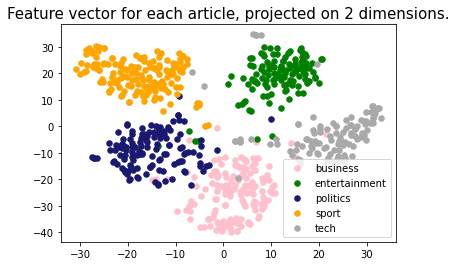

Accuracy:  0.9673469387755103



Weighted Pretrained GloVe: tSNE 2 dimensional projected Feature space


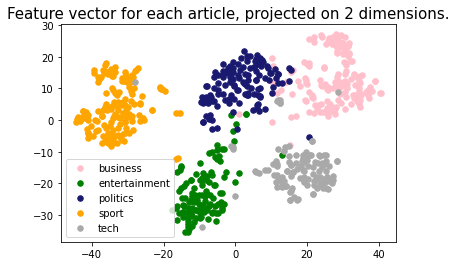

Accuracy:  0.9700680272108844



Weighted In-house Word2Vec: tSNE 2 dimensional projected Feature space


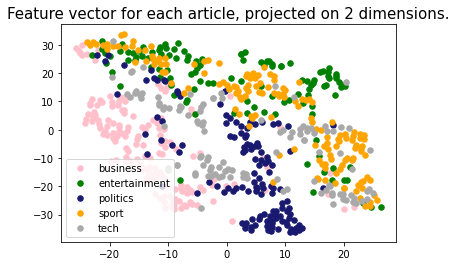

Accuracy:  0.8979591836734694



Weighted In-house FastText: tSNE 2 dimensional projected Feature space


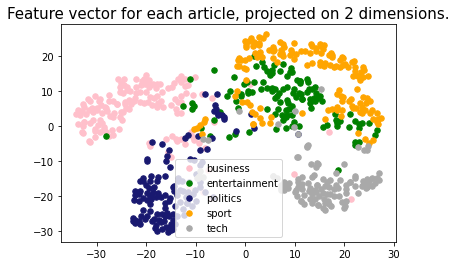

Accuracy:  0.9428571428571428





In [32]:
%matplotlib inline
seed = 0
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

models = [weighted_preTW2v_dvs,weighted_preTGloVe_dvs,weighted_bbcW2v_dvs,weighted_bbcFT_dvs]
model_names = ["Weighted Pretrained Word2Vec", "Weighted Pretrained GloVe", "Weighted In-house Word2Vec","Weighted In-house FastText"]
for i in range(0,len(models)): #loop through each model
    dv = models[i]
    name = model_names[i]
    features = dv.to_numpy() # convert the dataframe stored features to an numpy array
    print(name + ": tSNE 2 dimensional projected Feature space")
    plotTSNE(df['Category'],features)
    
    # creating training and test split
    X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(dv, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

    model = LogisticRegression(max_iter = 2000,random_state=seed)
    model.fit(X_train, y_train)
    print("Accuracy: ", model.score(X_test, y_test))
    print('\n\n')

#### Note: Creating tfidf weighted document embeddings using Gensim

In the previous sections, we tried very hard to create the tfidf weighted document embeddings using the generated tf-idf weights save in previous activity. 
Indeed, we can using Genism to do this direction, and it's indeed, a bit less effor required 😑 Will show you below. 
We will use the in-house build Word2Vec model as an example.

In [33]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

# we have two vocabularies here, one from the in-house bulit Word2Vec, the other from the articles 
# note that althought the Word2Vec is built on the same dataset, but they might have done further 
# pre-processing during model build (e.g., setting min_count), and thus, might create mismatch in the two vocabularis. 
# therefore, we remove tokenized words that doesn't exist in the keyedvectors in the Word2Vec keyedvectors
processed_text = [[w for w in t if w in bbcW2v_wv.index_to_key] for t in df['tk_text']] 

# use the Gensim package to create a dictionary that encapsulates the mapping between normalized words and their integer ids.
docs_dict = Dictionary(processed_text) # creates a dictionary from the text
docs_dict.filter_extremes(no_below=5) # filtering words that appear less than 5 times
docs_dict.compactify() # assign new word ids to all words, shrinking any gaps.

2021-06-03 16:24:59,112 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-06-03 16:24:59,433 : INFO : built Dictionary(9869 unique tokens: ['ability', 'acts', 'added', 'amounting', 'applications']...) from 2225 documents (total 386939 corpus positions)
2021-06-03 16:24:59,433 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(9869 unique tokens: ['ability', 'acts', 'added', 'amounting', 'applications']...) from 2225 documents (total 386939 corpus positions)", 'datetime': '2021-06-03T16:24:59.433946', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'created'}
2021-06-03 16:24:59,440 : INFO : discarding 1222 tokens: [('physio', 4), ('confess', 2), ('hassan', 2), ('mido', 2), ('roma', 4), ('arrese', 4), ('mcenroe', 3), ('scarlets', 4), ('diving', 3), ('said', 1888)]...
2021-06-03 16:24:59,442 : INFO : keeping 8647 tokens which were in no less than 5 and no more tha

In [34]:
# see what are the words that been get rid off when we do the fliter
[w for w in bbcW2v_wv.index_to_key if w not in docs_dict.values()]

['said',
 'it',
 're',
 've',
 'we',
 'up',
 'anti',
 'that',
 'didn',
 'he',
 'co',
 'can',
 'll',
 'there',
 'one',
 'pre',
 'they',
 'you',
 'doesn',
 'two',
 'to',
 'so',
 'on',
 'off',
 'isn',
 'mails',
 'in',
 'fi',
 'back',
 'first',
 'wasn',
 'all',
 'full',
 'non',
 'ex',
 'gara',
 'us',
 'wouldn',
 'three',
 'wi',
 'out',
 'haven',
 'semi',
 'driscoll',
 'five',
 'top',
 'well',
 'four',
 'forsyth',
 'couldn',
 'no',
 'what',
 'hi',
 'she',
 'ballet',
 'wal',
 'mart',
 'blu',
 'show',
 'third',
 'side',
 'multi',
 'connor',
 'rover',
 'firefox',
 'francis',
 'over',
 'spider',
 'simonetti',
 'commodore',
 'callaghan',
 'of',
 'connell',
 'cairn',
 'iptv',
 'aren',
 'rfid',
 'uwb',
 'skype',
 'hasn',
 'shouldn',
 'have',
 'juninho',
 'mcletchie',
 'casinos',
 'qantas',
 'cabir',
 'for',
 'millan',
 'southcorp',
 'wmc',
 'exeem',
 'hsdpa',
 'aragones',
 'tps',
 'qwest',
 'toulousain',
 'fannie',
 'under',
 'mate',
 'argonaut',
 'enhancing',
 'dyer',
 'regiments',
 'mutu',
 'cyb

In [35]:
len(docs_dict.keys())

8647

This process yields a vocabulary with 8647 words. 
Then we use Gensim again to create a bag-of-words representation of each document, i.e., the TF-IDF vector for each document.


In [36]:
import numpy as np
from gensim.matutils import sparse2full

docs_corpus = [docs_dict.doc2bow(doc) for doc in df['tk_text']] # convert corpus to Bag of Word format
model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict) # fit the tfidf model
# apply model to the list of corpus document, 
# so each document is a list of tuples, (word_index, weight) for each word appears in the document
docs_tfidf  = model_tfidf[docs_corpus]

2021-06-03 16:25:18,983 : INFO : collecting document frequencies
2021-06-03 16:25:18,983 : INFO : PROGRESS: processing document #0
2021-06-03 16:25:19,035 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 2225 documents and 8647 features (264775 matrix non-zeros)', 'datetime': '2021-06-03T16:25:19.035671', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'initialize'}


In [37]:
# see for example, the tfidf weights of the words in the 2nd document
docs_tfidf[1]

[(0, 0.037585188351134724),
 (2, 0.015923414755672056),
 (7, 0.05822225982983302),
 (12, 0.07896578001299367),
 (25, 0.026077652797470197),
 (29, 0.03041070091465139),
 (31, 0.019897206572352263),
 (41, 0.031204750199672046),
 (44, 0.01909468815668866),
 (46, 0.036138725342624044),
 (52, 0.02219809207349025),
 (57, 0.016992806344911324),
 (60, 0.05954653921789411),
 (68, 0.012216591043295186),
 (69, 0.10588382441880882),
 (78, 0.05898368572990021),
 (86, 0.05683265479463029),
 (87, 0.024709557351865957),
 (96, 0.02458108414087194),
 (109, 0.06153004407372585),
 (116, 0.03555926324639878),
 (122, 0.022408776361915007),
 (123, 0.05898368572990021),
 (124, 0.0555896107326925),
 (125, 0.037331457999419726),
 (126, 0.03953280033983175),
 (127, 0.052494235401860385),
 (128, 0.04262817567066388),
 (129, 0.20575750040328514),
 (130, 0.10893028119951251),
 (131, 0.10910346014473972),
 (132, 0.04477920660593382),
 (133, 0.1359508382290516),
 (134, 0.04501755828074591),
 (135, 0.05161990905528946

We can then transfer `docs_tfidf` to matrix form. `vstack` function from numpy can stack arrays in sequence vertically (row wise), and `sparse2full` function convert a document in sparse document format (in size of the number of words in the document) into a dense numpy array (of size of the vocabulary)

In [38]:
docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])

In [39]:
docs_vecs.shape

(2225, 8647)

In [40]:
docs_vecs[0]

array([0.05752827, 0.14894336, 0.07311762, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

The result, `docs_vecs`, is a matrix with 2225 rows (docs) and 8647 columns (TF-IDF terms). 

Let's see the performance of this TF-IDF vector:

In [41]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(docs_vecs, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9782312925170068

Wow~ quite good!

Now try to use this tfidf vector to create the weighted document embeddings.

Be careful, the vocabulary are different, for instance, 

In [42]:
# see how many words are encoded in our in-house Word2Vec model?
len(bbcW2v_wv.index_to_key)

9998

In [43]:
# how about the tfidf vector?
len(docs_dict)

8647

We only care about words that are in both vocabulary. 
In the following, we creates the word embeddings arrays for words exists in docs_dict

In [44]:
word_emb_vecs = np.vstack([bbcW2v_wv[docs_dict[i]] for i in range(len(docs_dict)) if docs_dict[i] in bbcW2v_wv.index_to_key])

In [45]:
word_emb_vecs.shape

(8647, 100)

In [46]:
word_emb_vecs[0]

array([-0.2929201 ,  0.44457227,  0.41661334, -0.00993503,  0.12797031,
       -0.6215264 ,  0.14019178,  0.5527939 , -0.46134558, -0.05682324,
       -0.16148178, -0.62420964,  0.15920155,  0.23741966,  0.07914773,
       -0.2960291 , -0.16056931, -0.18296768, -0.06547142, -0.59747607,
       -0.16486514,  0.3039937 ,  0.01969554, -0.44235092, -0.03527321,
       -0.10167501, -0.00954183, -0.37184316, -0.18727455, -0.18727255,
        0.5133642 ,  0.11516113,  0.3015071 ,  0.3856861 , -0.2136822 ,
        0.33342192,  0.60101795, -0.14174055, -0.43594658, -0.36434993,
        0.3322594 , -0.31728825, -0.2502729 ,  0.2547167 , -0.0708171 ,
       -0.13206714, -0.3474598 ,  0.1698129 ,  0.07031036,  0.03475913,
       -0.3329973 , -0.3925153 , -0.07029969,  0.075527  , -0.17690136,
        0.18067658,  0.43381363, -0.07157449, -0.03161514,  0.13418654,
        0.31219614, -0.05191116, -0.0993911 , -0.449641  , -0.16066386,
       -0.13596892, -0.33118725,  0.16445424, -0.2921404 ,  0.36

Now we can do the dot product of the two vectors and get our tfidf weighted document embeddings:

In [47]:
tfidf_docs_emb = np.dot(docs_vecs, word_emb_vecs) 

In [48]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(tfidf_docs_emb, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9034013605442177

Not much difference from the one we did ourselves (refer to the performance of the `Weighted In-house Word2Vec`.
Comparing the performance of the tfidf weighted document emeddings with our in-house built Word2Vec and the non-weighted on (referring to Section 2), adding the tfidf weight indeed worsen the results in this example. 
Indeed, in this example, the most simply bag-of-word tfidf vector representatino words much better, i.e., 0.978 accuracy 😆

> **Discussion**
Does adding the tfidf weight to construct document embedding and/or having a more complicated model guarantees higher performance?


##  5. Doc2Vec Model

In this very last section, we are going to quickly demonstrate the document to vector model implemented by Genism. 
Instead of suming up individual word embeddings to construct a document embedding, we can directly use the `Doc2Vec` model from Genism to directly generate document embedding.

In [49]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# creates a tagged version of documents using the indexes of document as the tags, 
# prepare as input to the Doc2Vec model
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['tk_text'])] 

In [50]:
documents[2]

TaggedDocument(words=['doherty', 'on-stage', 'fight', 'rock', 'singer', 'pete', 'doherty', 'involved', 'fight', "band's", 'guitarist', 'biggest', 'gig', 'date', 'babyshambles', 'played', 'fans', "london's", 'brixton', 'academy', 'tuesday', 'libertines', 'singer', 'traded', 'blows', 'guitarist', 'patrick', 'walden', 'separated', 'bundled', 'stage', 'returning', 'end', 'set', 'earlier', 'held', 'audience', 'overcrowding', 'monday', 'doherty', 'faced', 'blackmail', 'robbery', 'charges', 'court', 'denies', 'bail', 'judge', 'agreed', 'extend', 'gmt', 'curfew', 'deadline', 'hours', 'play', 'brixton', 'gig', 'babyshambles', 'formed', 'acrimonious', 'departure', 'libertines', 'played', 'warm-up', 'garage', 'north', 'london', 'monday', 'tuesday', 'doherty', 'bandmates', 'introduced', 'crowd', 'mick', 'jones', 'clash', 'guitarist', 'produced', 'second', 'album', 'babyshambles', 'took', 'stage', 'reception', 'gmt', 'launching', 'single', 'reached', 'number', 'december', 'group', 'stop', 'song', '

In [51]:
bbcD2V = Doc2Vec(documents, vector_size=100) # fit the Doc2Vec mode, with vector size of 100
print(bbcD2V)

2021-06-03 16:25:22,454 : INFO : collecting all words and their counts
2021-06-03 16:25:22,455 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-06-03 16:25:22,526 : INFO : collected 18349 word types and 2225 unique tags from a corpus of 2225 examples and 425145 words
2021-06-03 16:25:22,527 : INFO : Creating a fresh vocabulary
2021-06-03 16:25:22,560 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 10488 unique words (57.15842825222083%% of original 18349, drops 7861)', 'datetime': '2021-06-03T16:25:22.560388', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  4 2020, 02:22:02) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.14.6-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2021-06-03 16:25:22,561 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 403917 word corpus (95.00688000564513%% of original 425145, drops 21228)', 'datetime': '2021-06-03T16:25:22.561073', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep 

Doc2Vec(dm/m,d100,n5,w5,mc5,s0.001,t3)


Have a look at the embedding of the first document:

In [52]:
bbcD2V.dv[0]

array([ 0.11454982, -0.032353  , -0.00071478,  0.00174901,  0.14497268,
       -0.13748005,  0.06508344,  0.37048393, -0.20666318, -0.17072585,
        0.02386918, -0.14049186, -0.16397001, -0.00455213, -0.01752029,
       -0.07008539,  0.08772267, -0.03954367,  0.02102946,  0.0091915 ,
        0.10841979,  0.10877393,  0.04509874,  0.07008179,  0.0984271 ,
       -0.10320791, -0.0389216 ,  0.01583009, -0.02334722, -0.14877997,
        0.11507697,  0.08543792, -0.01775257,  0.07316525, -0.07908443,
       -0.03500553,  0.05572459, -0.00335365,  0.06653854, -0.13826336,
        0.19994949, -0.12722845,  0.05407086,  0.01734333,  0.06343144,
        0.00669588, -0.25352228,  0.13913569,  0.24033725,  0.03761184,
       -0.0200149 ,  0.05118918,  0.04512421, -0.05603988, -0.0424746 ,
        0.07957385,  0.06290326, -0.05604059, -0.08414457,  0.00919532,
        0.03603332,  0.23975326, -0.05192368,  0.01331474, -0.08390708,
        0.26071724,  0.08207896,  0.09352902, -0.09987403,  0.05

Explore its feature space, know that we do not need to convert the document vectors `bbcD2V.dv` to numpy array, as it is already a numpy array. :)

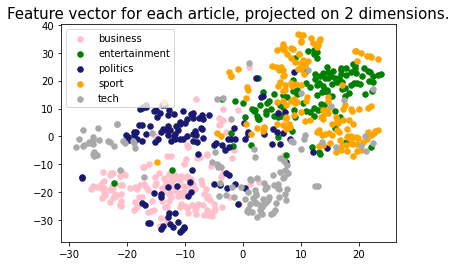

In [54]:

plotTSNE(df['Category'],bbcD2V.dv)

er...... seems not that great. 
Finally, let's build a logistic regression model for document classfication based on that:

In [55]:
# creating training and test split
X_train, X_test, y_train, y_test,train_indices,test_indices = train_test_split(bbcD2V.dv, df['Category'], list(range(0,len(df))),test_size=0.33, random_state=seed)

model = LogisticRegression(max_iter = 1000,random_state=seed)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8408163265306122

er...... not as great 🤨

### Infer vector for a new document:

Anyway, if we were to adopt this model in some other applicaitons. 
For a new document, we can easily infer the document vector embeddings. Just look at the following example:

In [59]:
headline = """
Chelsea boss Thomas Tuchel has challenged Kai Havertz to show greater "hunger and determination" after the forward 
impressed in a dominant victory at Crystal Palace.
"""

# This is a sport news headline


In [78]:
from gensim.utils import simple_preprocess

doc_vec = bbcD2V.infer_vector(simple_preprocess(headline))
doc_vec

array([ 0.01627132,  0.01884041,  0.02272608,  0.00397928,  0.04112453,
       -0.07675812,  0.00797929,  0.0941938 , -0.04472687, -0.07459433,
        0.00401609, -0.02161853, -0.09820293,  0.02484406, -0.05144409,
       -0.02508348,  0.03704153, -0.05414223,  0.00354637,  0.04342475,
        0.02274181,  0.02220371,  0.09736038, -0.01129432,  0.05073708,
       -0.04289461,  0.04479956, -0.01034958, -0.00844936, -0.0949089 ,
        0.02510142,  0.05808383, -0.00469825,  0.06541745, -0.0140554 ,
       -0.00569261, -0.00806472,  0.00111972,  0.04123918, -0.05153571,
        0.10586244, -0.06095417,  0.0506042 , -0.03120329,  0.0067398 ,
        0.02296279, -0.13869114,  0.05641207,  0.06898411,  0.03726583,
       -0.04221537,  0.02057075,  0.01869616,  0.03474297, -0.0214555 ,
        0.03905592,  0.03942374, -0.01645545, -0.04051245, -0.01926499,
        0.03686599,  0.10806303, -0.08938402, -0.00577636, -0.02820241,
        0.07479814,  0.0344021 ,  0.02097556, -0.02456789,  0.03

Once we got the document embedding, we can do the prediction. Let's see whether it gets it right:

In [81]:
model.predict([doc_vec])

array(['entertainment'], dtype=object)

Cool! 🤩 It gets the right class (I hope you got the same, but maybe you have different results....)
Try as many as you want and have fun! 😊

If you run the infer_vecotr multiple time, every time you get a different vector. and thus, when you predict the class based on the different document vectors, you may get different results. 🤪 🤪 🤪 
Refer to the answer of the [this question](https://github.com/RaRe-Technologies/gensim/wiki/recipes-&-faq#q12-ive-used-doc2vec-infer_vector-on-a-single-text-but-the-resulting-vector-is-different-each-time-is-there-a-bug-or-have-i-made-a-mistake-doc2vec-inference-non-determinism) to understand why. 


## Summary

Phew~~ this is a big activity. I got exhausted written it up and I believe you got a bit exhaused looking through it too 🤣
Give yourself a clap! Well done! 👏👏👏



## Exericse:
Ok, we leave a few exercises for you:
- We have try vector size 100 so far, but there are many alternatives, e.g., 50,200,300. Try other size and report performance. Discuss and share your thoughts with your peers: does larger vector size guarantees better performance?
- So far, in this activities, we have been using the cleaned articles. Many of these libraries (including Genism) has included functionalities to do simply cleaning of text. Try them on and compare the performance.
- Oh, one other very important thing. The results we presented so for in this activity, are based on a single run. To report more robust results, you should do Cross validation. Implement cross validation on the models we explore in this activity, and do a comprehensive comparsion on them.
    


## References
[1] [TFIDF with Word Embeddings](https://github.com/ytnvj2/DocumentEmbedding/blob/master/TFIDFwithEmbeddings.ipynb)  
[2] [Problem-solving with ML: automatic document classification](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification)     
[3] [Creating TF-IDF Weighted Word Embeddings](http://dsgeek.com/2018/02/19/tfidf_vectors.html)    